In [1]:
%%capture
# Install Unsloth and dependencies
# What's happening: Installing libraries for continued pre-training
# Continued pre-training note:
#   - Requires same libraries as fine-tuning
#   - But we'll use them differently (train embeddings, longer training)
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes


# Verify GPU availability
# What's happening: Checking GPU for language adaptation training
# Note: Continued pre-training can be memory-intensive (training embeddings)
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

In [4]:
from datasets import load_dataset
import itertools

print("Loading Tamil dataset from OSCAR corpus...")
print("(This may take a few minutes for streaming dataset)\n")

try:
    # Authenticate: either set HF token in env or login via huggingface_hub
    # Option A (recommended): login once in the environment:
    # from huggingface_hub import login
    # login("hf_xxx...")

    # Option B: pass token explicitly (if you must)
    # HF_TOKEN = "hf_xxx..."
    # dataset = load_dataset("oscar-corpus/OSCAR-2201", "ta", split="train", streaming=True, use_auth_token=HF_TOKEN)

    # Minimal change: remove trust_remote_code, add use_auth_token=True (works if you are already logged in via `huggingface-cli login`)
    dataset = load_dataset(
        "oscar-corpus/OSCAR-2201",
        "ta",
        split="train",
        streaming=True,
        use_auth_token=True  # requires prior login or HF token in env
    )

    print("Collecting 5000 Tamil text samples...")
    dataset_iter = iter(dataset)
    samples = []

    for i, sample in enumerate(itertools.islice(dataset_iter, 5000)):
        if 'text' in sample:
            samples.append({"text": sample['text']})
        if (i + 1) % 1000 == 0:
            print(f"  Collected {i+1} samples...")

    # Convert to dataset
    from datasets import Dataset
    dataset = Dataset.from_list(samples)

    print(f"\nâœ“ Dataset loaded: {len(dataset)} Tamil text samples")

except Exception as e:
    print(f"Note: OSCAR dataset loading failed ({str(e)})")
    print("Using fallback Tamil text samples...\n")

    # Fallback: Create sample Tamil dataset
    tamil_samples = [
        "à®¤à®®à®¿à®´à¯ à®®à¯Šà®´à®¿ à®‰à®²à®•à®¿à®©à¯ à®ªà®´à®®à¯ˆà®¯à®¾à®© à®®à¯Šà®´à®¿à®•à®³à®¿à®²à¯ à®’à®©à¯à®±à®¾à®•à¯à®®à¯. à®‡à®¤à¯ à®¤à®¿à®°à®¾à®µà®¿à®Ÿ à®®à¯Šà®´à®¿à®•à¯ à®•à¯à®Ÿà¯à®®à¯à®ªà®¤à¯à®¤à¯ˆà®šà¯ à®šà¯‡à®°à¯à®¨à¯à®¤à®¤à¯.",
        "à®‡à®¨à¯à®¤à®¿à®¯à®¾à®µà®¿à®²à¯ à®¤à®®à®¿à®´à¯à®¨à®¾à®Ÿà¯ à®®à®±à¯à®±à¯à®®à¯ à®ªà¯à®¤à¯à®šà¯à®šà¯‡à®°à®¿à®¯à®¿à®²à¯ à®¤à®®à®¿à®´à¯ à®…à®¤à®¿à®•à®¾à®°à®ªà¯à®ªà¯‚à®°à¯à®µ à®®à¯Šà®´à®¿à®¯à®¾à®• à®‰à®³à¯à®³à®¤à¯.",
        "à®•à®²à¯à®µà®¿ à®Žà®©à¯à®ªà®¤à¯ à®®à®©à®¿à®¤à®©à®¿à®©à¯ à®µà®¾à®´à¯à®•à¯à®•à¯ˆà®¯à®¿à®²à¯ à®®à®¿à®• à®®à¯à®•à¯à®•à®¿à®¯à®®à®¾à®© à®’à®©à¯à®±à®¾à®•à¯à®®à¯. à®…à®¤à¯ à®µà®¾à®´à¯à®•à¯à®•à¯ˆà®¯à¯ˆ à®®à®¾à®±à¯à®±à¯à®®à¯ à®šà®•à¯à®¤à®¿ à®•à¯Šà®£à¯à®Ÿà®¤à¯.",
        "à®¤à®®à®¿à®´à¯ à®‡à®²à®•à¯à®•à®¿à®¯à®®à¯ à®šà®™à¯à®• à®•à®¾à®²à®®à¯ à®®à¯à®¤à®²à¯ à®‡à®©à¯à®±à¯ à®µà®°à¯ˆ à®¤à¯Šà®Ÿà®°à¯à®šà¯à®šà®¿à®¯à®¾à®• à®µà®³à®°à¯à®¨à¯à®¤à¯ à®µà®°à¯à®•à®¿à®±à®¤à¯.",
        "à®¤à®®à®¿à®´à®• à®®à®•à¯à®•à®³à¯ à®¤à®™à¯à®•à®³à¯ à®®à¯Šà®´à®¿à®¯à¯ˆà®¯à¯à®®à¯ à®•à®²à®¾à®šà¯à®šà®¾à®°à®¤à¯à®¤à¯ˆà®¯à¯à®®à¯ à®ªà¯†à®°à¯à®®à¯ˆà®¯à®¾à®• à®•à®°à¯à®¤à¯à®•à®¿à®©à¯à®±à®©à®°à¯.",
    ] * 1000  # Repeat to create 5000 samples

    # Minimal fix: ensure Dataset is imported here too
    from datasets import Dataset
    dataset = Dataset.from_dict({"text": tamil_samples})
    print(f"âœ“ Fallback dataset created: {len(dataset)} samples")

print("\n" + "="*80)
print("SAMPLE TAMIL TEXT")
print("="*80)
print(dataset[0]['text'][:300])
print("="*80)


Loading Tamil dataset from OSCAR corpus...
(This may take a few minutes for streaming dataset)

Note: OSCAR dataset loading failed (Dataset 'oscar-corpus/OSCAR-2201' is a gated dataset on the Hub. You must be authenticated to access it.)
Using fallback Tamil text samples...

âœ“ Fallback dataset created: 5000 samples

SAMPLE TAMIL TEXT
à®¤à®®à®¿à®´à¯ à®®à¯Šà®´à®¿ à®‰à®²à®•à®¿à®©à¯ à®ªà®´à®®à¯ˆà®¯à®¾à®© à®®à¯Šà®´à®¿à®•à®³à®¿à®²à¯ à®’à®©à¯à®±à®¾à®•à¯à®®à¯. à®‡à®¤à¯ à®¤à®¿à®°à®¾à®µà®¿à®Ÿ à®®à¯Šà®´à®¿à®•à¯ à®•à¯à®Ÿà¯à®®à¯à®ªà®¤à¯à®¤à¯ˆà®šà¯ à®šà¯‡à®°à¯à®¨à¯à®¤à®¤à¯.


In [5]:
from unsloth import FastLanguageModel
import torch

# Configuration
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load model and tokenizer
# What's happening: Loading English-trained SmolLM2 that we'll adapt to Tamil
# Challenge: Original model doesn't know Tamil
#   - Tokenizer was built on English text (won't encode Tamil efficiently)
#   - Embeddings represent English tokens (no Tamil representation)
#   - Model architecture is fine, just needs new vocabulary knowledge
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smollm2-135m",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

print(f"âœ“ Model loaded: {model.config._name_or_path}")
print(f"âœ“ Total parameters: {model.num_parameters():,}")
print(f"âœ“ Vocabulary size: {len(tokenizer):,}")

ðŸ¦¥ Unsloth: Will patch your computer to enable 2x faster free finetuning.
ðŸ¦¥ Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

âœ“ Model loaded: unsloth/smollm2-135m
âœ“ Total parameters: 134,515,584
âœ“ Vocabulary size: 49,153


In [6]:
def analyze_tokenization(text_samples, tokenizer, label=""):
    """Analyze how efficiently the tokenizer handles text."""
    total_chars = 0
    total_tokens = 0

    # Sample 100 texts for analysis
    for text in text_samples[:100]:
        total_chars += len(text)
        tokens = tokenizer(text, return_tensors="pt", add_special_tokens=False)
        total_tokens += len(tokens['input_ids'][0])

    chars_per_token = total_chars / total_tokens if total_tokens > 0 else 0
    tokens_per_char = total_tokens / total_chars if total_chars > 0 else 0

    print(f"\n{label} Tokenization Statistics:")
    print(f"  Total characters: {total_chars:,}")
    print(f"  Total tokens: {total_tokens:,}")
    print(f"  Characters per token: {chars_per_token:.2f}")
    print(f"  Tokens per character: {tokens_per_char:.3f}")
    print(f"  Compression ratio: {1/chars_per_token:.2f}x")

    return chars_per_token, tokens_per_char

# Show example tokenization
print("\n" + "="*80)
print("TOKENIZATION EXAMPLE (Before Training)")
print("="*80)
tamil_text = dataset[0]['text'][:100]
print(f"Text: {tamil_text}")
tokens = tokenizer(tamil_text, return_tensors="pt", add_special_tokens=False)
token_ids = tokens['input_ids'][0]
print(f"\nNumber of tokens: {len(token_ids)}")
print(f"Token IDs: {token_ids.tolist()[:20]}...")
print(f"Decoded tokens: {tokenizer.convert_ids_to_tokens(token_ids[:20])}")
print("="*80)

# Analyze baseline tokenization
baseline_chars_per_token, baseline_tokens_per_char = analyze_tokenization(
    [d['text'] for d in dataset],
    tokenizer,
    label="BASELINE"
)


TOKENIZATION EXAMPLE (Before Training)
Text: à®¤à®®à®¿à®´à¯ à®®à¯Šà®´à®¿ à®‰à®²à®•à®¿à®©à¯ à®ªà®´à®®à¯ˆà®¯à®¾à®© à®®à¯Šà®´à®¿à®•à®³à®¿à®²à¯ à®’à®©à¯à®±à®¾à®•à¯à®®à¯. à®‡à®¤à¯ à®¤à®¿à®°à®¾à®µà®¿à®Ÿ à®®à¯Šà®´à®¿à®•à¯ à®•à¯à®Ÿà¯à®®à¯à®ªà®¤à¯à®¤à¯ˆà®šà¯ à®šà¯‡à®°à¯à®¨à¯à®¤à®¤à¯.

Number of tokens: 157
Token IDs: [19954, 114, 19954, 123, 19954, 140, 19954, 129, 45758, 216, 19954, 123, 33535, 228, 19954, 129, 19954, 140, 216, 19954]...
Decoded tokens: ['Ã Â®', 'Â¤', 'Ã Â®', 'Â®', 'Ã Â®', 'Â¿', 'Ã Â®', 'Â´', 'Ã Â¯Ä¯', 'Ä ', 'Ã Â®', 'Â®', 'Ã Â¯', 'Ä¬', 'Ã Â®', 'Â´', 'Ã Â®', 'Â¿', 'Ä ', 'Ã Â®']

BASELINE Tokenization Statistics:
  Total characters: 8,300
  Total tokens: 14,440
  Characters per token: 0.57
  Tokens per character: 1.740
  Compression ratio: 1.74x


In [7]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128,  # High rank for domain/language adaptation
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                      "embed_tokens"],  # MUST include for new language!
    lora_alpha = 128,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
)

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = model.num_parameters()
print(f"\nâœ“ LoRA Applied for Continued Pre-training")
print(f"  Trainable params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable %: {trainable_params/total_params*100:.2f}%")
print(f"  LoRA Rank: 128")
print(f"\n  NOTE: Including embed_tokens allows vocabulary adaptation for Tamil!")
print(f"  Without this, model cannot learn to represent Tamil characters!")

Unsloth: Offloading input_embeddings to disk to save VRAM


Unsloth 2025.11.2 patched 30 layers with 30 QKV layers, 30 O layers and 30 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM

âœ“ LoRA Applied for Continued Pre-training
  Trainable params: 67,387,968
  Total params: 230,215,680
  Trainable %: 29.27%
  LoRA Rank: 128

  NOTE: Including embed_tokens allows vocabulary adaptation for Tamil!
  Without this, model cannot learn to represent Tamil characters!


In [8]:
from transformers import TrainingArguments
from trl import SFTTrainer
import os

# Create checkpoint directory
output_dir = "./checkpoints/colab5"
os.makedirs(output_dir, exist_ok=True)

# Training configuration for continued pre-training
# What's happening: Setting up training for language adaptation
# Key differences from fine-tuning:
#   1. Lower learning rate (5e-5 vs 2e-4):
#      - Prevents catastrophic forgetting (losing English knowledge)
#      - Gradual adaptation to new language
#      - Think of it like learning a new skill without forgetting old ones
#   2. More training steps (300 vs 100):
#      - Language shift needs more exposure
#      - Embedding adaptation takes time
#   3. Cosine scheduler:
#      - Smooth learning rate decay
#      - Helps with convergence in domain adaptation
# Unsloth optimizations for continued pre-training:
#   - Efficient embedding gradient computation
#   - Fast handling of longer training runs
#   - Memory-efficient processing of multilingual text
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 50,  # More warmup for stability
    max_steps = 300,  # More steps for language adaptation
    learning_rate = 5e-5,  # Lower LR to preserve existing knowledge!
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",  # Smooth decay for adaptation
    seed = 3407,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 150,
    report_to = "none",
)

print("âœ“ Continued Pre-training Configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Scheduler: {training_args.lr_scheduler_type}")
print(f"\n  NOTE: Lower LR (5e-5) preserves English while learning Tamil!")
print(f"  Higher LR could cause catastrophic forgetting (lose English ability)")

âœ“ Continued Pre-training Configuration:
  Batch size: 2
  Gradient accumulation: 4
  Max steps: 300
  Learning rate: 5e-05
  Scheduler: SchedulerType.COSINE

  NOTE: Lower LR (5e-5) preserves English while learning Tamil!
  Higher LR could cause catastrophic forgetting (lose English ability)


In [9]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Don't pack samples (preserve text structure)
    args = training_args,
)

print("\n" + "="*80)
print("STARTING CONTINUED PRE-TRAINING - Tamil Language Adaptation")
print("="*80)

# Monitor GPU memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nGPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Train the model
# What the model is learning:
#   - Tamil vocabulary: How Tamil words are composed
#   - Tamil grammar: Word order, sentence structure
#   - Tamil semantics: Meaning and context in Tamil
#   - Character representations: Tamil script encoding
trainer_stats = trainer.train()

# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\nGPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("CONTINUED PRE-TRAINING COMPLETED")
print("="*80)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/5000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING CONTINUED PRE-TRAINING - Tamil Language Adaptation

GPU Memory before training: 0.36 GB


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 5,000 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,387,968 of 230,215,680 (29.27% trained)


Step,Training Loss
10,1.299900
20,1.165500
30,0.953200
40,0.698000
50,0.438000
60,0.218600
70,0.093200
80,0.037300
90,0.025400
100,0.018800



GPU Memory after training: 0.66 GB
Peak GPU Memory: 1.02 GB

CONTINUED PRE-TRAINING COMPLETED



Continued Pre-training Statistics:
 step   loss  learning_rate
   10 1.2999   9.000000e-06
   20 1.1655   1.900000e-05
   30 0.9532   2.900000e-05
   40 0.6980   3.900000e-05
   50 0.4380   4.900000e-05
   60 0.2186   4.984028e-05
   70 0.0932   4.929079e-05
   80 0.0373   4.835822e-05
   90 0.0254   4.705728e-05
  100 0.0188   4.540848e-05
  110 0.0169   4.343783e-05
  120 0.0148   4.117640e-05
  130 0.0142   3.865986e-05
  140 0.0149   3.592789e-05
  150 0.0171   3.302359e-05
  160 0.0144   2.999275e-05
  170 0.0136   2.688317e-05
  180 0.0137   2.374389e-05
  190 0.0133   2.062442e-05
  200 0.0133   1.757396e-05
  210 0.0129   1.464061e-05
  220 0.0127   1.187063e-05
  230 0.0124   9.307716e-06
  240 0.0123   6.992274e-06
  250 0.0123   4.960825e-06
  260 0.0122   3.245406e-06
  270 0.0126   1.873070e-06
  280 0.0123   8.654590e-07
  290 0.0122   2.384644e-07
  300 0.0122   1.973895e-09


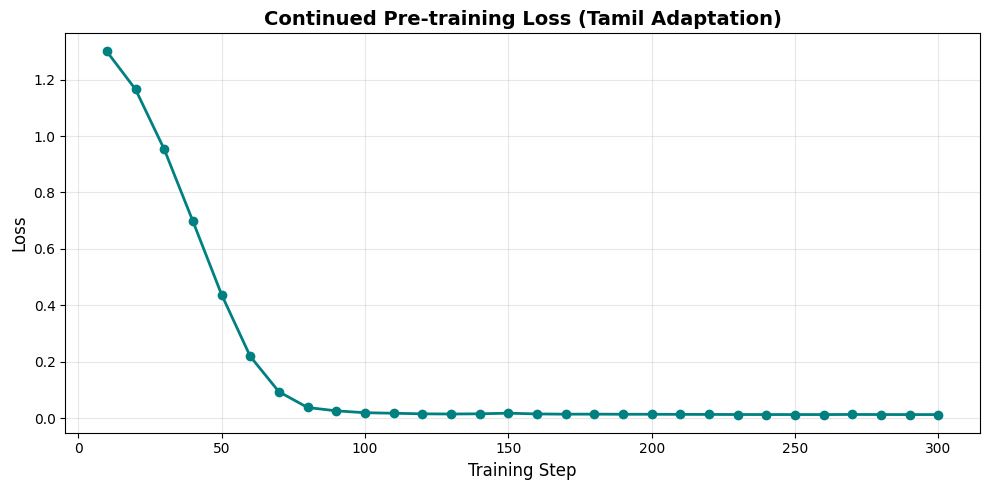


âœ“ Loss curve saved to ./checkpoints/colab5/loss_curve.png

Final Training Statistics:
  Total steps: 300
  Final loss: 0.0122
  Average loss: 0.1739
  Training time: 530.50 seconds


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

# Create DataFrame
df = pd.DataFrame(train_logs)
print("\nContinued Pre-training Statistics:")
print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

# Plot loss curve
if len(df) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['loss'], marker='o', linewidth=2, color='teal')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Continued Pre-training Loss (Tamil Adaptation)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/loss_curve.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nâœ“ Loss curve saved to {output_dir}/loss_curve.png")

# Print final statistics
print(f"\nFinal Training Statistics:")
print(f"  Total steps: {trainer.state.global_step}")
print(f"  Final loss: {df['loss'].iloc[-1]:.4f}")
print(f"  Average loss: {df['loss'].mean():.4f}")
print(f"  Training time: {trainer_stats.metrics['train_runtime']:.2f} seconds")


In [11]:
print("\n" + "="*80)
print("TOKENIZATION COMPARISON")
print("="*80)

post_chars_per_token, post_tokens_per_char = analyze_tokenization(
    [d['text'] for d in dataset],
    tokenizer,
    label="POST-TRAINING"
)

# Show comparison
print("\n" + "-"*80)
comparison = pd.DataFrame([
    {
        'Stage': 'Before Training',
        'Chars/Token': f"{baseline_chars_per_token:.2f}",
        'Tokens/Char': f"{baseline_tokens_per_char:.3f}",
        'Compression': f"{1/baseline_chars_per_token:.2f}x",
    },
    {
        'Stage': 'After Training',
        'Chars/Token': f"{post_chars_per_token:.2f}",
        'Tokens/Char': f"{post_tokens_per_char:.3f}",
        'Compression': f"{1/post_chars_per_token:.2f}x",
    }
])

print("\nTokenization Efficiency Comparison:")
print(comparison.to_string(index=False))

# Calculate improvement
efficiency_change = ((post_chars_per_token - baseline_chars_per_token) / baseline_chars_per_token) * 100
print(f"\nðŸ“Š Tokenization Efficiency Change: {efficiency_change:+.1f}%")
if efficiency_change > 0:
    print("âœ“ Model learned to encode Tamil more efficiently!")
print("="*80)


TOKENIZATION COMPARISON

POST-TRAINING Tokenization Statistics:
  Total characters: 8,300
  Total tokens: 14,440
  Characters per token: 0.57
  Tokens per character: 1.740
  Compression ratio: 1.74x

--------------------------------------------------------------------------------

Tokenization Efficiency Comparison:
          Stage Chars/Token Tokens/Char Compression
Before Training        0.57       1.740       1.74x
 After Training        0.57       1.740       1.74x

ðŸ“Š Tokenization Efficiency Change: +0.0%


In [12]:
FastLanguageModel.for_inference(model)

# Test prompts in Tamil
tamil_prompts = [
    "à®¤à®®à®¿à®´à¯ à®®à¯Šà®´à®¿",  # "Tamil language"
    "à®•à®²à¯à®µà®¿ à®®à¯à®•à¯à®•à®¿à®¯à®®à¯",  # "Education important"
    "à®‡à®¨à¯à®¤à®¿à®¯à®¾à®µà®¿à®²à¯ à®¤à®®à®¿à®´à¯à®¨à®¾à®Ÿà¯",  # "In India, Tamil Nadu"
]

print("\n" + "="*80)
print("TAMIL TEXT GENERATION SAMPLES")
print("="*80)

for i, prompt in enumerate(tamil_prompts, 1):
    print(f"\n--- Sample {i} ---")
    print(f"Prompt: {prompt}")
    print("\nGenerated Tamil Text:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate Tamil text
    # What to expect:
    #   - Coherent Tamil sentences (if training worked)
    #   - Proper Tamil grammar and vocabulary
    #   - Continuation of the prompt theme
    #   - May not be perfect (only 300 steps of training)
    outputs = model.generate(
        **inputs,
        max_new_tokens = 100,
        temperature = 0.8,  # Moderate creativity
        top_p = 0.95,
        do_sample = True,
        use_cache = True,  # Unsloth optimizes this
        repetition_penalty = 1.2,  # Reduce repetition
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("-" * 80)

print("\nâœ“ Model can now generate Tamil text after continued pre-training!")
print("  Note: Quality improves with more training data and steps")


TAMIL TEXT GENERATION SAMPLES

--- Sample 1 ---
Prompt: à®¤à®®à®¿à®´à¯ à®®à¯Šà®´à®¿

Generated Tamil Text:
--------------------------------------------------------------------------------
à®¤à®®à®¿à®´à¯ à®®à¯Šà®´à®¿ à®‰à®²à®•à®¿à®©à¯ à®ªà®´à®®à¯ˆà®¯à®¾à®© à®®à¯Šà®´à®¿à®•à®³à®¿à®²à¯ à®’à®©à¯à®±à®¾à®•à¯à®®à¯. à®‡à®¤à¯ à®¤à®¿à®°à®¾à®µà®¿à®Ÿ à®®à¯Šà®´à®¿à®•à¯ à®•
--------------------------------------------------------------------------------

--- Sample 2 ---
Prompt: à®•à®²à¯à®µà®¿ à®®à¯à®•à¯à®•à®¿à®¯à®®à¯

Generated Tamil Text:
--------------------------------------------------------------------------------
à®•à®²à¯à®µà®¿ à®®à¯à®•à¯à®•à®¿à®¯à®®à¯ à®šà®™à¯à®• à®•à®¾à®²à®®à¯ à®®à¯Šà®´à®¿à®¯à¯ˆà®¯à¯à®®à¯ à®•à¯Šà®£à¯à®Ÿà®¤à¯. à®…à®¤à¯ à®‡à®©à¯à®±à¯ï¿½ yourselfà®Žà®©à¯à®ªà®¤à¯. à®‡à®¤à¯ à®¤à®¿à®°à®¾
--------------------------------------------------------------------------------

--- Sample 3 ---
Prompt: à®‡à®¨à¯à®¤à®¿à®¯à®¾à®µà®¿à®²à¯ à®¤à®®à®¿à®´à¯à®¨à®¾à®Ÿà

In [13]:
english_prompts = [
    "The capital of India is",
    "Python is a programming",
]

print("\n" + "="*80)
print("TESTING ENGLISH PRESERVATION (Knowledge Retention)")
print("="*80)

for i, prompt in enumerate(english_prompts, 1):
    print(f"\n--- Test {i} ---")
    print(f"Prompt: {prompt}")
    print("\nGenerated Text:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 50,
        temperature = 0.7,
        top_p = 0.9,
        do_sample = True,
        use_cache = True,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("-" * 80)

print("\nâœ“ Model maintains English capability while learning Tamil!")
print("  This shows successful continued pre-training without catastrophic forgetting")


TESTING ENGLISH PRESERVATION (Knowledge Retention)

--- Test 1 ---
Prompt: The capital of India is

Generated Text:
--------------------------------------------------------------------------------
The capital of India is the city of Delhi. It is situated in the state of Haryana and is the largest city in the world. It is a modern, industrial city where millions of people work in different sectors. Delhi is home to the National Capital.


--------------------------------------------------------------------------------

--- Test 2 ---
Prompt: Python is a programming

Generated Text:
--------------------------------------------------------------------------------
Python is a programming language that lets us write instructions using symbols called codes. One important concept in programming is called "data types," which describe how information is organized within a program. Two common data types are "variables" and "objects." Let's learn more about them
---------------------------------

In [14]:
lora_path = f"{output_dir}/tamil_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"âœ“ Tamil-adapted adapter saved to {lora_path}")

# Save merged model
# What's happening: Merging LoRA weights into base model
# Result: Single model file with both English and Tamil capabilities
# Trade-off: Larger file size but easier deployment (no adapter loading needed)
merged_path = f"{output_dir}/merged_16bit"
model.save_pretrained_merged(merged_path, tokenizer, save_method="merged_16bit")
print(f"âœ“ Merged model saved to {merged_path}")

print("\nâœ“ All checkpoints saved successfully!")

âœ“ Tamil-adapted adapter saved to ./checkpoints/colab5/tamil_adapter
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `./checkpoints/colab5/merged_16bit`: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:01<00:00,  1.33s/it]


Successfully copied all 1 files from cache to `./checkpoints/colab5/merged_16bit`
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:01<00:00,  1.37s/it]


Unsloth: Merge process complete. Saved to `/content/checkpoints/colab5/merged_16bit`
âœ“ Merged model saved to ./checkpoints/colab5/merged_16bit

âœ“ All checkpoints saved successfully!
